# Fine-Tuning BERT Model for Italian Group Reference Recognition

### Author: Qi Yu

In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.cuda.set_device(0)
torch.cuda.current_device()

0

In [3]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from datasets import Dataset, DatasetDict, load_metric
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer, DataCollatorForTokenClassification

2023-10-20 08:48:40.843193: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
RANDOM_STATE = 42
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed_all(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

# 1. Read in dataset

In [5]:
dataset_dict = {
    "long": "./data/segmented_sentences_less_sparse.pkl",
    "short": "./data/segmented_sentences_less_sparse_short.pkl",
}

**Comment out one of the lines in the following cell to choose which dataset to use (long or short version):**

In [6]:
MODE = "long"
#MODE = "short"

In [7]:
df = pd.read_pickle(dataset_dict[MODE])
df

,document_index,document_text_tokenized,token_labels_binary,token_labels_iob
0,0,"[Il, 7, agosto, 1721, sposò, il, principe, ere...","[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0]","[O, O, O, O, O, B, I, I, I, I, I, I, I, O]"
1,0,"[Alla, morte, di, Federico, IV, ,, nel, 1730, ...","[0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, ...","[O, O, B, I, I, O, O, O, O, B, O, O, O, O, B, ..."
2,1,"[Saluto, a, nome, dell', Assemblea, i, docenti...","[0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, ...","[O, O, O, B, I, B, I, O, B, I, O, O, O, O, O, ..."
3,2,"[Quando, Cassie, viene, a, conoscenza, di, qua...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[O, B, O, O, O, O, O, O, O, O, O]"
4,2,"[Non, capisce, come, Edmund, possa, aver, fatt...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[O, O, O, B, O, O, O, O, O, O, O, O, O, O, O, ..."
...,...,...,...,...
5343,997,"[Questo, perché, ,, a, seguito, della, costruz...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
5345,998,"[Verso, la, fine, del, XIX, secolo, ,, la, sto...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
5346,998,"[A, testimonianza, di, ciò, ,, in, Irlanda, in...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, ...","[O, O, O, O, O, O, O, O, O, O, B, I, I, I, O, ..."
5347,999,"[Nel, 1738, Goldoni, diede, al, teatro, San, S...","[0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...","[O, O, B, O, O, O, B, I, O, O, O, O, O, O, O, ..."


**Exclude unused columns:**

In [8]:
df = df.loc[:, ["document_text_tokenized", "token_labels_binary"]]
df = df.rename(columns={"document_text_tokenized": "text", "token_labels_binary": "label"})
df

,text,label
0,"[Il, 7, agosto, 1721, sposò, il, principe, ere...","[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0]"
1,"[Alla, morte, di, Federico, IV, ,, nel, 1730, ...","[0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, ..."
2,"[Saluto, a, nome, dell', Assemblea, i, docenti...","[0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, ..."
3,"[Quando, Cassie, viene, a, conoscenza, di, qua...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,"[Non, capisce, come, Edmund, possa, aver, fatt...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...
5343,"[Questo, perché, ,, a, seguito, della, costruz...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5345,"[Verso, la, fine, del, XIX, secolo, ,, la, sto...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5346,"[A, testimonianza, di, ciò, ,, in, Irlanda, in...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, ..."
5347,"[Nel, 1738, Goldoni, diede, al, teatro, San, S...","[0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, ..."


# 2. Train-test split

**Divide the dataset into training, validation and test set in a 80/10/10 fashion:**

In [9]:
df_train, df_val_test = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE)
df_val, df_test = train_test_split(df_val_test, test_size=0.5, random_state=RANDOM_STATE)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

dataset = DatasetDict({
    "train": Dataset.from_pandas(df_train),
    "validation": Dataset.from_pandas(df_val),
    "test": Dataset.from_pandas(df_test)
})

dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 2968
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 371
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 372
    })
})

**Get dataset statistics:**

In [10]:
def get_dataset_statistics(dataframe):
    total_token_count = 0
    gr_count = 0

    for label_list in dataframe["label"]:
        total_token_count += len(label_list)
        gr_count += len(list(filter(lambda x: x == 1, label_list)))
    
    print("Number of tokens: {}".format(total_token_count))
    print("Number of tokens labeled as group reference: {}".format(gr_count))

    all_lengths = [len(i) for i in  dataframe["label"]]

    plt.hist(all_lengths, bins=20, color='blue', edgecolor='black')
    plt.xlabel('Document Length')
    plt.ylabel('Frequency')
    plt.show()

Number of tokens: 106482
Number of tokens labeled as group reference: 18043


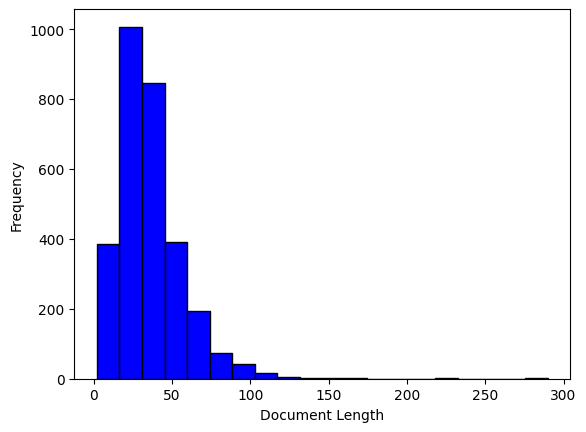

In [11]:
get_dataset_statistics(df_train)

Number of tokens: 13495
Number of tokens labeled as group reference: 2379


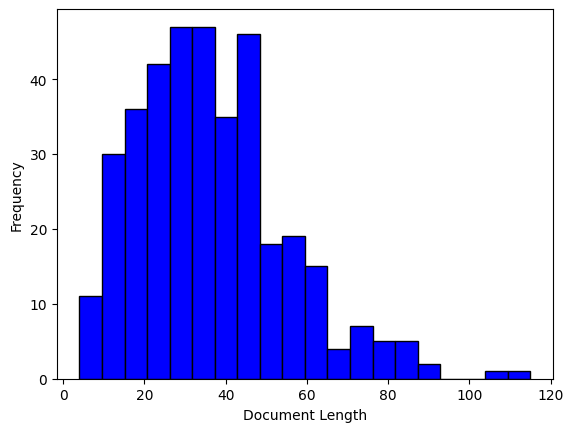

In [12]:
get_dataset_statistics(df_val)

Number of tokens: 13821
Number of tokens labeled as group reference: 2433


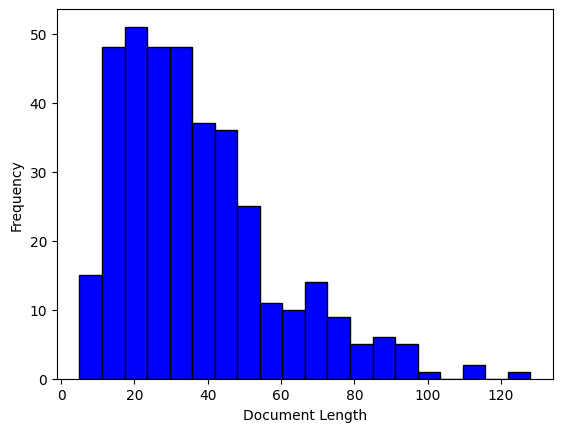

In [13]:
get_dataset_statistics(df_test)

# 3. Train model

In [14]:
MODEL_CHECKPOINT = "dbmdz/bert-base-italian-cased"

## 3.1 Tokenization

In [15]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

**Run tokenizer on all texts to find out the maximal length:**

In [16]:
max_len = 0

for text in df["text"]:
    input_ids = tokenizer.encode(text, 
                                 is_split_into_words=True)
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  329


**Propagate a word's original label to wordpieces:**

Reference:
https://medium.com/@andrewmarmon/fine-tuned-named-entity-recognition-with-hugging-face-bert-d51d4cb3d7b5

In [17]:
def tokenize_and_align_labels(examples):
    label_all_tokens = True
    
    tokenized_inputs = tokenizer(
        examples["text"], 
        is_split_into_words=True,  
        padding = "max_length", 
        truncation = True, 
        max_length = max_len,
        return_tensors="pt"
    )

    labels = []
    
    for i, label in enumerate(examples["label"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            else:
                if word_idx != previous_word_idx:
                    label_ids.append(label[word_idx])
                else:
                    label_ids.append(label[previous_word_idx])
                    
            previous_word_idx = word_idx
        
        labels.append(label_ids)
        
    tokenized_inputs["labels"] = labels
    
    return tokenized_inputs

In [18]:
train_tokenized_datasets = dataset["train"].map(tokenize_and_align_labels, batched=True, remove_columns=["text", "label"])
val_tokenized_datasets = dataset["validation"].map(tokenize_and_align_labels, batched=True, remove_columns=["text", "label"])
test_tokenized_datasets = dataset["test"].map(tokenize_and_align_labels, batched=True, remove_columns=["text", "label"])

Map:   0%|          | 0/2968 [00:00<?, ? examples/s]

Map:   0%|          | 0/371 [00:00<?, ? examples/s]

Map:   0%|          | 0/372 [00:00<?, ? examples/s]

## 3.2 Training and tuning hyperparameters

**Define hyperparameters:**

Using 2 Epochs: we observed that the validation loss start increasing largely after the 2nd epoch, indicating an overfit.

In [19]:
# Specifying batch size: For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.
BATCH_SIZE = 16

# Number of training epochs (authors recommend between 2 and 4)
EPOCHS = 2

In [20]:
model = AutoModelForTokenClassification.from_pretrained(MODEL_CHECKPOINT, num_labels=2)

Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at

In [21]:
args = TrainingArguments(
    f"bert-base-italian-cased-ner",
    evaluation_strategy = "epoch",
    learning_rate = 1e-4, 
    per_device_train_batch_size = BATCH_SIZE,
    per_device_eval_batch_size = BATCH_SIZE,
    num_train_epochs = EPOCHS,
    weight_decay=1e-5,
    logging_steps=50
)

In [22]:
data_collator = DataCollatorForTokenClassification(tokenizer, padding=False)

In [23]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)
    
    predictions_exclude_padding = [[p for (p, l) in zip(prediction, label) if l != -100] for prediction, label in zip(predictions, labels)]
    labels_exclude_padding = [[l for (p, l) in zip(prediction, label) if l != -100] for prediction, label in zip(predictions, labels)]

    flat_preds = [pred for sublist in predictions_exclude_padding for pred in sublist]
    flat_labels = [label for sublist in labels_exclude_padding for label in sublist]
    accuracy = accuracy_score(flat_labels, flat_preds)
    f1 = f1_score(flat_labels, flat_preds)
    
    #print(classification_report(flat_labels, flat_preds))
    
    return {"accuracy": accuracy, "f1": f1}

In [24]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_tokenized_datasets,
    eval_dataset=val_tokenized_datasets,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

/usr/local/jupyterhub/lib64/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2968
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 186
  Number of trainable parameters = 109338626
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/jupyterhub/lib64/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input te

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.223000,0.121286,0.956951,0.883448
2,0.075000,0.112498,0.962109,0.901212


***** Running Evaluation *****
  Num examples = 371
  Batch size = 32
/usr/local/jupyterhub/lib64/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 371
  Batch size = 32


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=186, training_loss=0.12998327516740368, metrics={'train_runtime': 63.2522, 'train_samples_per_second': 93.847, 'train_steps_per_second': 2.941, 'total_flos': 996675650951232.0, 'train_loss': 0.12998327516740368, 'epoch': 2.0})

In [25]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 371
  Batch size = 32
/usr/local/jupyterhub/lib64/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 0.11249785870313644,
 'eval_accuracy': 0.9621091511176209,
 'eval_f1': 0.901212020587747,
 'eval_runtime': 1.4551,
 'eval_samples_per_second': 254.966,
 'eval_steps_per_second': 8.247,
 'epoch': 2.0}

# 4. Evaluation

In [26]:
predictions, labels, _ = trainer.predict(test_tokenized_datasets)
predictions = np.argmax(predictions, axis=2)

predictions_exclude_padding = [[p for (p, l) in zip(prediction, label) if l != -100] for prediction, label in zip(predictions, labels)]
labels_exclude_padding = [[l for (p, l) in zip(prediction, label) if l != -100] for prediction, label in zip(predictions, labels)]

flat_preds = [pred for sublist in predictions_exclude_padding for pred in sublist]
flat_labels = [label for sublist in labels_exclude_padding for label in sublist]

print("Accuracy: ")
print(accuracy_score(flat_labels, flat_preds))
print()

print("Precision: ")
print(precision_score(flat_labels, flat_preds))
print()

print("Recall: ")
print(recall_score(flat_labels, flat_preds))
print()

print("F1: ")
print(f1_score(flat_labels, flat_preds))
print()

print("Classification Report: ")
print(classification_report(flat_labels, flat_preds))

***** Running Prediction *****
  Num examples = 372
  Batch size = 32
/usr/local/jupyterhub/lib64/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Accuracy: 
0.9641677572131863

Precision: 
0.8981366459627329

Recall: 
0.9213125199107997

F1: 
0.9095769775121875

Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.97      0.98     12908
           1       0.90      0.92      0.91      3139

    accuracy                           0.96     16047
   macro avg       0.94      0.95      0.94     16047
weighted avg       0.96      0.96      0.96     16047



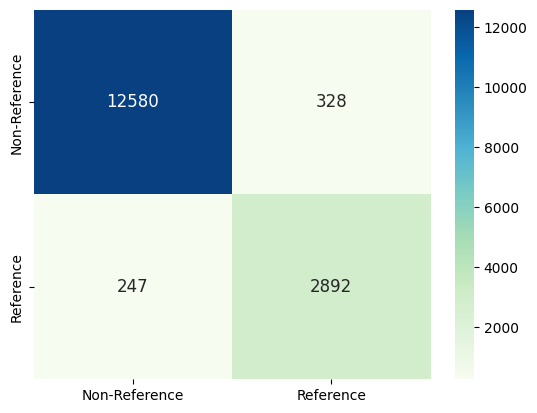

In [27]:
tick_labels = ["Non-Reference", "Reference"]

cm = confusion_matrix(flat_labels, flat_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="GnBu", yticklabels=tick_labels, xticklabels=tick_labels, annot_kws={'fontsize': 12})

plt.savefig("./results/confusion_matrix_" + MODE + ".pdf")

**Get prediction results:**

In [28]:
all_text_ids = []
all_tokens = []
all_pred = []
all_true = []

for i in range(len(test_tokenized_datasets)):
    current_tokens = tokenizer.convert_ids_to_tokens(test_tokenized_datasets['input_ids'][i], skip_special_tokens=False)
    
    all_tokens += current_tokens
    all_text_ids += [i] * len(current_tokens)
    all_pred += list(predictions[i])
    all_true += list(labels[i])

    if len(current_tokens) != len(predictions[i]):
        print(i)
        #print(curren_tokens)
        #print(predictions_exclude_padding[i])
        #print(labels_exclude_padding[i])
        print("--------")
        print()

In [29]:
df_pred = pd.DataFrame({
    "document_id": all_text_ids,
    "tokens": all_tokens,
    "pred": all_pred,
    "true": all_true
})

df_pred

,document_id,tokens,pred,true
0,0,[CLS],0,-100
1,0,Per,1,1
2,0,i,1,1
3,0,giornalisti,1,1
4,0,",",0,0
...,...,...,...,...
122383,371,[PAD],0,-100
122384,371,[PAD],0,-100
122385,371,[PAD],0,-100
122386,371,[PAD],0,-100


In [33]:
df_pred.to_csv("./results/all_predictions.csv")

**Get false positives:**

In [30]:
df_pred_fp = df_pred[(df_pred['pred'] == 1) & (df_pred['true'] == 0)]
df_pred_fp.to_csv("./results/false_positives.csv")

**Get false negatives:**

In [31]:
df_pred_fn = df_pred[(df_pred['pred'] == 0) & (df_pred['true'] == 1)]
df_pred_fn.to_csv("./results/false_negatives.csv")